# Build a DNN using the Keras Functional API




## Learning objectives

1. Review how to read in CSV file data using tf.data.
2. Specify input, hidden, and output layers in the DNN architecture.
3. Review and visualize the final DNN shape.
4. Train the model locally and visualize the loss curves.
5. Deploy and predict with the model using Cloud AI Platform. 


## Introduction

In this notebook, we will build a Keras DNN to predict the fare amount for NYC taxi cab rides.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/neural_network.ipynb).

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!sudo apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
  libgvpr2 liblab-gamut1 libpathplan4
Suggested packages:
  gsfonts graphviz-doc
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin
  libgvc6 libgvpr2 liblab-gamut1 libpathplan4
0 upgraded, 11 newly installed, 0 to remove and 2 not upgraded.
Need to get 3032 kB of archives.
After this operation, 11.5 MB of additional disk space will be used.
Get:1 https://deb.debian.org/debian bullseye/main amd64 fonts-liberation all 1:1.07.4-11 [828 kB]
Get:2 https://deb.debian.org/debian bullseye/main amd64 libann0 amd64 1.1.2+doc-7 [25.3 kB]
Err:3 https://deb.debian.org/debian bullseye/main amd64 libcdt5 amd64 2.42.2-5
  404  Not Found [IP: 151.101.38.132 443]
Err:4 https://deb.debian.org/debian bullsey

In [3]:
import os, json, math
import numpy as np
import shutil
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # SET TF ERROR LOG VERBOSITY

2024-09-21 00:09:01.329082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 00:09:07.813914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-09-21 00:09:07.815081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

TensorFlow version:  2.11.0


## Locating the CSV files

We will start with the CSV files that we wrote out in the other notebook. Just so you don't have to run the notebook, we saved a copy in ../data/toy_data

In [4]:
!ls -l ../data/toy_data/*.csv

-rw-r--r-- 1 jupyter jupyter 1111933 Sep 21 00:06 ../data/toy_data/taxi-traffic-test_toy.csv
-rw-r--r-- 1 jupyter jupyter 4772181 Sep 21 00:06 ../data/toy_data/taxi-traffic-train_toy.csv
-rw-r--r-- 1 jupyter jupyter 1038564 Sep 21 00:06 ../data/toy_data/taxi-traffic-valid_toy.csv


## Lab Task 1: Use tf.data to read the CSV files


First let's define our columns of data, which column we're predicting for, and the default values.

In [5]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

Next, let's define our features we want to use and our label(s) and then load in the dataset for training.

In [7]:
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
    dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
    return dataset

## Lab Task 2: Build a DNN with Keras

Now let's build the Deep Neural Network (DNN) model in Keras and specify the input and hidden layers. We will print out the DNN architecture and then visualize it later on.

In [8]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

    # TODO 2
    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in INPUT_COLS
    }
    # tf.feature_column.numeric_column() represents real valued or numerical features.
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dropoff_latitude (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 passenger_count (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None,)]            0           []                               
                                                        

## Lab Task 3: Visualize the DNN

We can visualize the DNN using the Keras [plot_model](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/utils/plot_model) utility.

In [9]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Lab Task 4: Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [10]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 32  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../data/toy_data/taxi-traffic-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../data/toy_data/taxi-traffic-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/32
48/48 [==============================] - 3s 24ms/step - loss: 124.8766 - rmse: 10.6666 - mse: 124.8766 - val_loss: 88.1567 - val_rmse: 9.3790 - val_mse: 88.1567
Epoch 2/32
48/48 [==============================] - 1s 11ms/step - loss: 92.6051 - rmse: 9.2604 - mse: 92.6051 - val_loss: 84.3374 - val_rmse: 9.1529 - val_mse: 84.3374
Epoch 3/32
48/48 [==============================] - 0s 10ms/step - loss: 96.4561 - rmse: 9.4215 - mse: 96.4561 - val_loss: 92.3379 - val_rmse: 9.5948 - val_mse: 92.3379
Epoch 4/32
48/48 [==============================] - 0s 10ms/step - loss: 88.9767 - rmse: 8.9027 - mse: 88.9767 - val_loss: 85.9544 - val_rmse: 9.2404 - val_mse: 85.9544
Epoch 5/32
48/48 [==============================] - 0s 10ms/step - loss: 90.1170 - rmse: 9.0067 - mse: 90.1170 - val_loss: 89.8749 - val_rmse: 9.4694 - val_mse: 89.8749
Epoch 6/32
48/48 [==============================] - 0s 10ms/step - loss: 68.7457 - rmse: 7.8166 - mse: 68.7457 - val_loss: 85.1552 - val_rmse: 9.1986 - 

### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

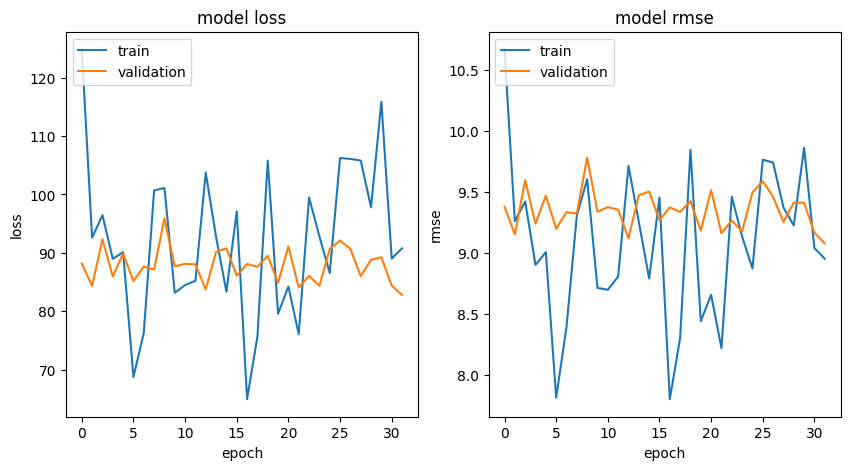

In [11]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Lab Task 5: Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

In [12]:
# TODO 5
# Use the model to do prediction with `model.predict()`
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
}, steps=1)

1/1 [==============================] - 0s 364ms/step


array([[39.455257]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.